In [84]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)
library(fastDummies)

Warning message:
"package 'fastDummies' was built under R version 3.6.3"

### Performance Function

In [89]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

In order to obtain the similar measure performance, a perf_dt function is written. In addition, if target variable categorical, confusionMatrix() function will be used for understanding performance of the model.

# Pisa Dataset

Reading Test Scores
The Programme for International Student Assessment (PISA) is a test given every three years to 15-year-old students from around the world to evaluate their performance in mathematics, reading, and science. This test provides a quantitative way to compare the performance of students from different parts of the world. In this homework assignment, we will predict the reading scores of students from the United States of America on the 2009 PISA exam.

The datasets pisa2009train.csv and pisa2009test.csv contain information about the demographics and schools for American students taking the exam, derived from 2009 PISA Public-Use Data Files distributed by the United States National Center for Education Statistics (NCES). While the datasets are not supposed to contain identifying information about students taking the test, by using the data you are bound by the NCES data use agreement, which prohibits any attempt to determine the identity of any student in the datasets.

Each row in the datasets pisa2009train.csv and pisa2009test.csv represents one student taking the exam. The datasets have the following variables:

grade: The grade in school of the student (most 15-year-olds in America are in 10th grade)

male: Whether the student is male (1/0)

raceeth: The race/ethnicity composite of the student

preschool: Whether the student attended preschool (1/0)

expectBachelors: Whether the student expects to obtain a bachelor's degree (1/0)

motherHS: Whether the student's mother completed high school (1/0)

motherBachelors: Whether the student's mother obtained a bachelor's degree (1/0)

motherWork: Whether the student's mother has part-time or full-time work (1/0)

fatherHS: Whether the student's father completed high school (1/0)

fatherBachelors: Whether the student's father obtained a bachelor's degree (1/0)

fatherWork: Whether the student's father has part-time or full-time work (1/0)

selfBornUS: Whether the student was born in the United States of America (1/0)

motherBornUS: Whether the student's mother was born in the United States of America (1/0)

fatherBornUS: Whether the student's father was born in the United States of America (1/0)

englishAtHome: Whether the student speaks English at home (1/0)

computerForSchoolwork: Whether the student has access to a computer for schoolwork (1/0)

read30MinsADay: Whether the student reads for pleasure for 30 minutes/day (1/0)

minutesPerWeekEnglish: The number of minutes per week the student spend in English class

studentsInEnglish: The number of students in this student's English class at school

schoolHasLibrary: Whether this student's school has a library (1/0)

publicSchool: Whether this student attends a public school (1/0)

urban: Whether this student's school is in an urban area (1/0)

schoolSize: The number of students in this student's school

readingScore: The student's reading score, on a 1000-point scale

### Loading Dataset

In [90]:
pisa_train=read.csv("pisa_train.csv")
pisa_test=read.csv("pisa_test.csv")
pisa_train=as.data.table(pisa_train,na.rm=TRUE)
pisa_test=as.data.table(pisa_test,na.rm=TRUE)
pisa_train=na.omit(pisa_train)
pisa_test=na.omit(pisa_test)

In [91]:
pisa_train$raceeth=as.factor(as.numeric(pisa_train$raceeth))
pisa_test$raceeth=as.factor(as.numeric(pisa_test$raceeth))

In this dataset, train and test dataset were seperated. 23 features exist in the data. Train input size is 2414 and test input size is 990. Namely, both of them exceeds the lower bound(200). In addition, target variable is "readingScore". readingScores take values in between 0 to 1000, which makes the dataset labeled. 

This dataset is proper for **Linear Regression** problems. Much as there is some wheter or not question, these values will be used as numeric. The **only factorial** feature is the **raceeth** representing the race of the students.

In [92]:
str(pisa_train)

Classes 'data.table' and 'data.frame':	2414 obs. of  24 variables:
 $ grade                : int  11 10 10 10 10 10 10 10 11 9 ...
 $ male                 : int  1 0 1 0 1 0 0 0 1 1 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 3 4 7 5 4 7 4 7 7 ...
 $ preschool            : int  0 1 1 1 1 1 1 1 1 1 ...
 $ expectBachelors      : int  0 1 0 1 1 1 1 0 1 1 ...
 $ motherHS             : int  1 0 1 1 1 1 1 0 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 0 0 0 0 1 ...
 $ motherWork           : int  1 1 1 0 1 1 1 0 0 1 ...
 $ fatherHS             : int  1 1 1 1 0 1 1 0 1 1 ...
 $ fatherBachelors      : int  0 0 0 0 0 0 1 0 1 1 ...
 $ fatherWork           : int  1 1 0 1 1 0 1 1 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 0 1 0 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 0 1 0 1 1 ...
 $ fatherBornUS         : int  1 1 0 1 1 0 1 0 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 0 1 0 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 0 1 1 1 1 ...
 $ read30M

In [93]:
str(pisa_test)

Classes 'data.table' and 'data.frame':	990 obs. of  24 variables:
 $ grade                : int  10 10 10 10 11 10 10 10 10 10 ...
 $ male                 : int  0 0 0 0 0 1 0 1 1 0 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 7 1 7 7 4 7 4 7 4 ...
 $ preschool            : int  1 1 1 1 0 1 0 1 1 1 ...
 $ expectBachelors      : int  0 1 0 0 0 1 1 0 1 1 ...
 $ motherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 1 0 0 1 0 ...
 $ motherWork           : int  1 0 0 1 1 1 0 1 1 1 ...
 $ fatherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBachelors      : int  0 1 0 0 1 0 0 0 1 1 ...
 $ fatherWork           : int  0 1 0 1 1 1 1 0 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 1 1 1 1 1 ...
 $ read30M

# Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [94]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure = "mse")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mse_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.min, standardize = FALSE)
lasso_model_pisa_mse_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.1se, standardize = FALSE)
lasso_model_pisa_mse_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda[10], standardize = FALSE)

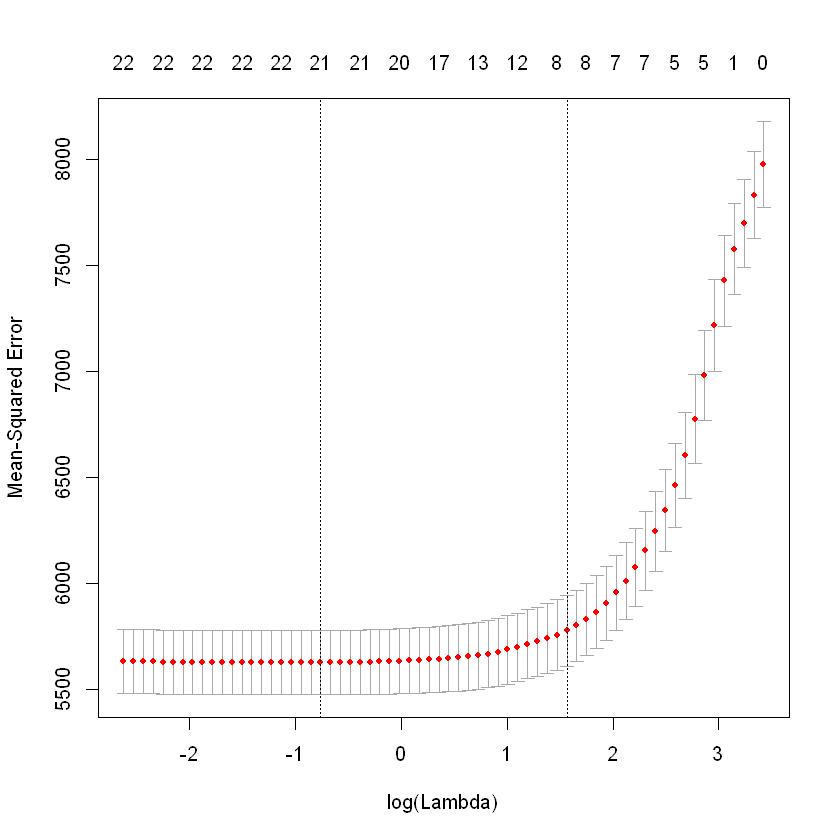

In [95]:
plot(cvfit_pisa)

### Lambda Values for Mean Square Error Values

In [96]:
cvfit_pisa$lambda.min

[1] 0.4673544

In [97]:
cvfit_pisa$lambda.1se

[1] 4.783518

In [98]:
cvfit_pisa$lambda[10]

[1] 13.31042

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [99]:
prediction_pra_mse_pisa_min <- predict(lasso_model_pisa_mse_min, s = cvfit_pisa$lambda.min, newx = test_mat_pisa)
prediction_pra_mse_pisa_1se <- predict(lasso_model_pisa_mse_1se, s = cvfit_pisa$lambda.1se, newx = test_mat_pisa)
prediction_pra_mse_pisa_10th <- predict(lasso_model_pisa_mse_10th, s = cvfit_pisa$lambda[10], newx = test_mat_pisa)

## L1 Penalty with Mean Absolute Error measure

In [100]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa_mae=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure="mae")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mae_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.min, standardize = FALSE)
lasso_model_pisa_mae_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.1se, standardize = FALSE)
lasso_model_pisa_mae_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda[10], standardize = FALSE)

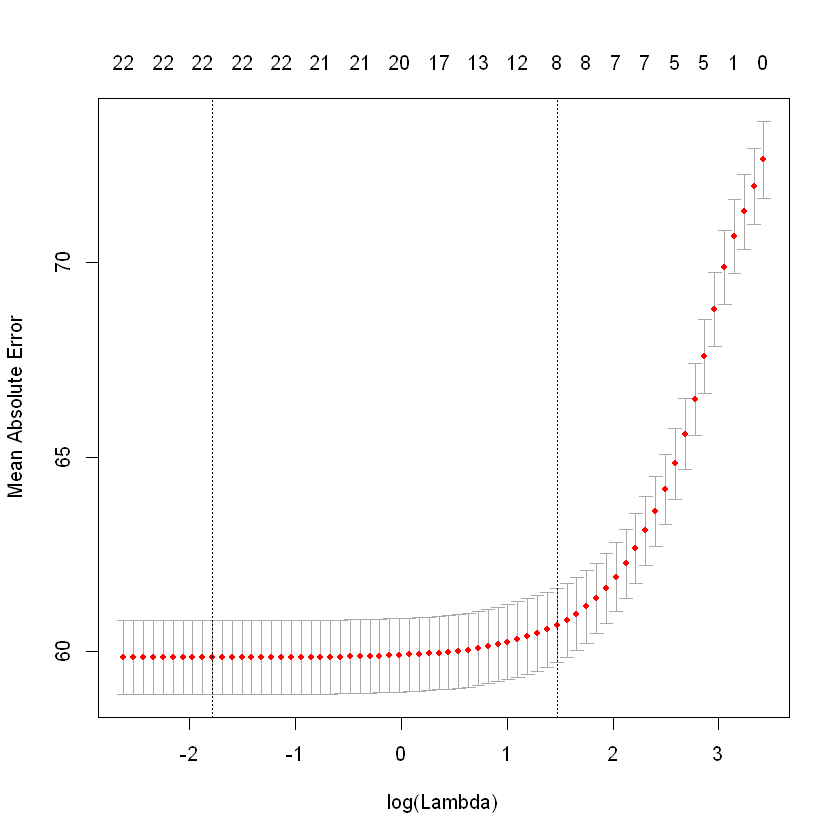

In [101]:
plot(cvfit_pisa_mae)

### Lambda Values for Mean Absolute Error Values

In [102]:
cvfit_pisa_mae$lambda.min

[1] 0.1679585

In [103]:
cvfit_pisa_mae$lambda.1se

[1] 4.358563

In [104]:
cvfit_pisa_mae$lambda[10]

[1] 13.31042

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [105]:
prediction_pra_mae_pisa_min <- predict(lasso_model_pisa_mae_min, s = cvfit_pisa_mae$lambda.min, newx = test_mat_pisa)
prediction_pra_mae_pisa_1se <- predict(lasso_model_pisa_mae_1se, s = cvfit_pisa_mae$lambda.1se, newx = test_mat_pisa)
prediction_pra_mae_pisa_10th <- predict(lasso_model_pisa_mae_10th, s = cvfit_pisa_mae$lambda[10], newx = test_mat_pisa)

### Performance Measure for Lasso Regression

In [106]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_10th)

perf_dt("Pisa Data Set for Lasso Function with min lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_10th)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007024564,0.1220858,2.43564,60.6515,0.116668


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mse objective,990,519.8643,88.80043,0.005745756,0.1260195,2.495768,62.26346,0.1197687


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mse objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mae objective,990,519.8643,88.80043,0.007086702,0.1222803,2.440891,60.78138,0.1169178


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mae objective,990,519.8643,88.80043,0.00595535,0.1254263,2.486058,62.00751,0.1192763


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mae objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


# Decision Tree(DT)

In [107]:
set.seed(35)

In [122]:
pisa_train_dt=cbind(pisa_train,dummy_cols(pisa_train$raceeth)[2:8])
pisa_test_dt=cbind(pisa_test,dummy_cols(pisa_test$raceeth)[2:8])
pisa_train_dt[,raceeth:=NULL]
pisa_test_dt[,raceeth:=NULL]

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2174, 2171, 2174, 2172, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  85.34171  0.1947043  68.64251
  0.01  79.13922  0.2175422  63.31365
  0.02  81.15992  0.1772923  65.28153
  0.03  81.62003  0.1675409  65.65334
  0.04  81.62003  0.1675409  65.65334
  0.05  81.62003  0.1675409  65.65334
  0.06  83.93531  0.1194084  67.76816
  0.07  83.86643  0.1208509  67.73574
  0.08  83.86643  0.1208509  67.73574
  0.09  83.86643  0.1208509  67.73574
  0.10  83.86643  0.1208509  67.73574

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.
CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2172, 2173, 2172, 2172, 2173, 2174, ... 
Resampling results across tuning parameters:

  cp    RMSE   

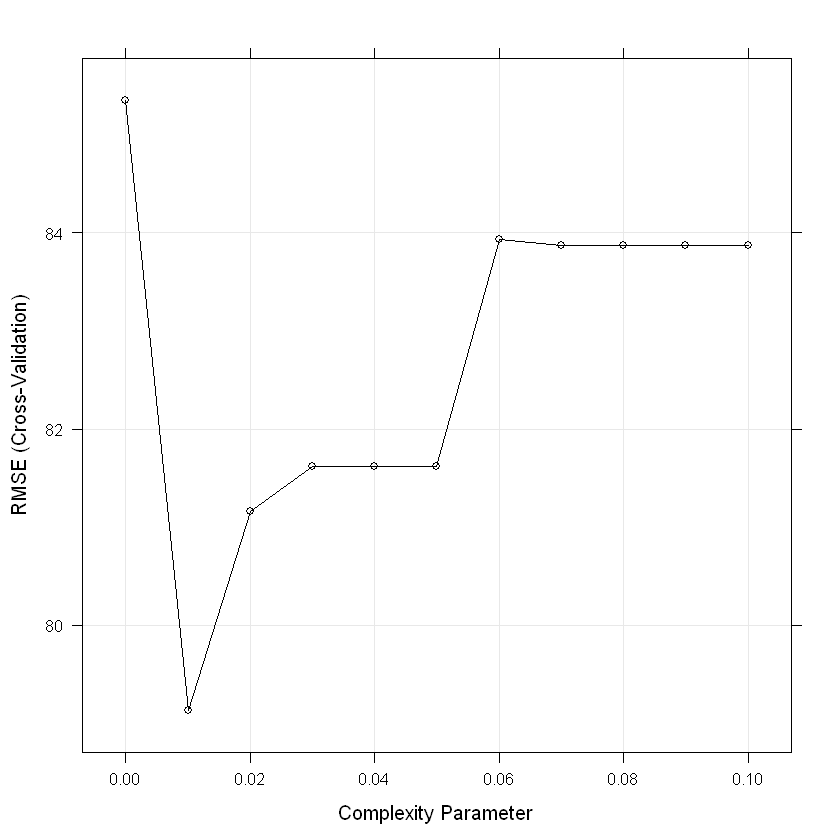

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2171, 2174, 2171, 2173, 2173, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  83.15021  0.2035019  66.50858
  0.01  79.25359  0.2141516  63.48474
  0.02  80.95378  0.1794562  65.05690
  0.03  81.17936  0.1746005  65.32148
  0.04  81.17936  0.1746005  65.32148
  0.05  81.68697  0.1638289  65.74420
  0.06  83.76105  0.1210452  67.59915
  0.07  83.84070  0.1191038  67.72701
  0.08  83.84070  0.1191038  67.72701
  0.09  83.84070  0.1191038  67.72701
  0.10  83.84070  0.1191038  67.72701

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


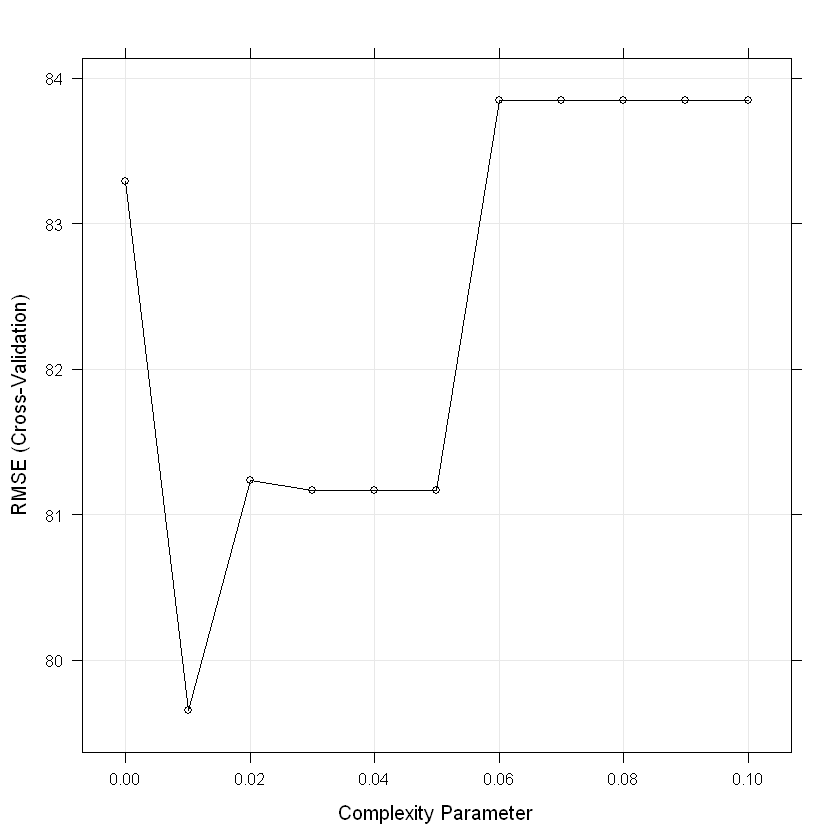

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2173, 2174, 2171, 2174, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  82.80938  0.2027363  66.05323
  0.01  80.20876  0.1976242  64.37162
  0.02  81.30453  0.1741430  65.27891
  0.03  81.47629  0.1698002  65.41198
  0.04  81.47629  0.1698002  65.41198
  0.05  81.47629  0.1698002  65.41198
  0.06  83.89903  0.1190744  67.75281
  0.07  83.83057  0.1204079  67.73415
  0.08  83.83057  0.1204079  67.73415
  0.09  83.83057  0.1204079  67.73415
  0.10  83.83057  0.1204079  67.73415

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


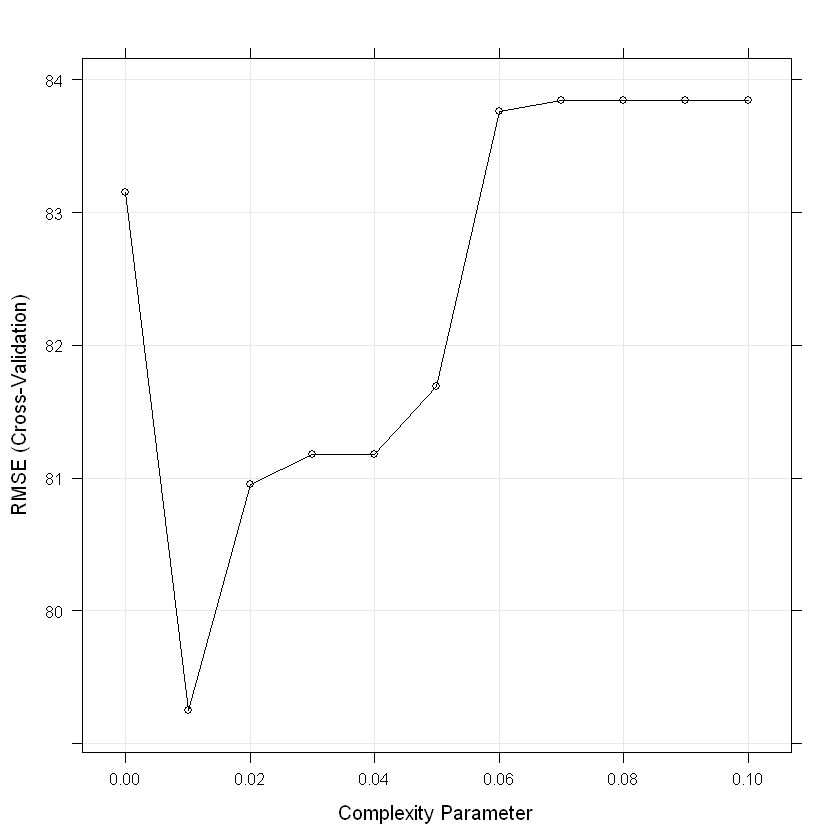

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2171, 2174, 2173, 2173, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  81.32760  0.2164133  65.13267
  0.01  79.92593  0.2029090  64.02004
  0.02  80.80460  0.1834732  64.86095
  0.03  81.14820  0.1763910  65.29176
  0.04  81.14820  0.1763910  65.29176
  0.05  81.14820  0.1763910  65.29176
  0.06  83.83607  0.1219902  67.73594
  0.07  83.83607  0.1219902  67.73594
  0.08  83.83607  0.1219902  67.73594
  0.09  83.83607  0.1219902  67.73594
  0.10  83.83607  0.1219902  67.73594

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


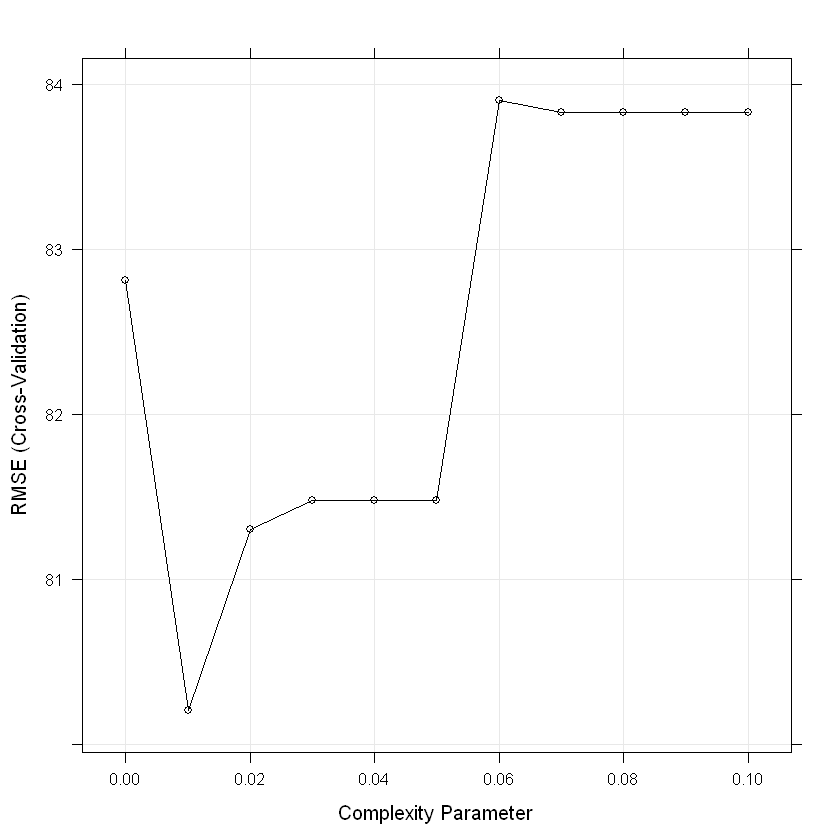

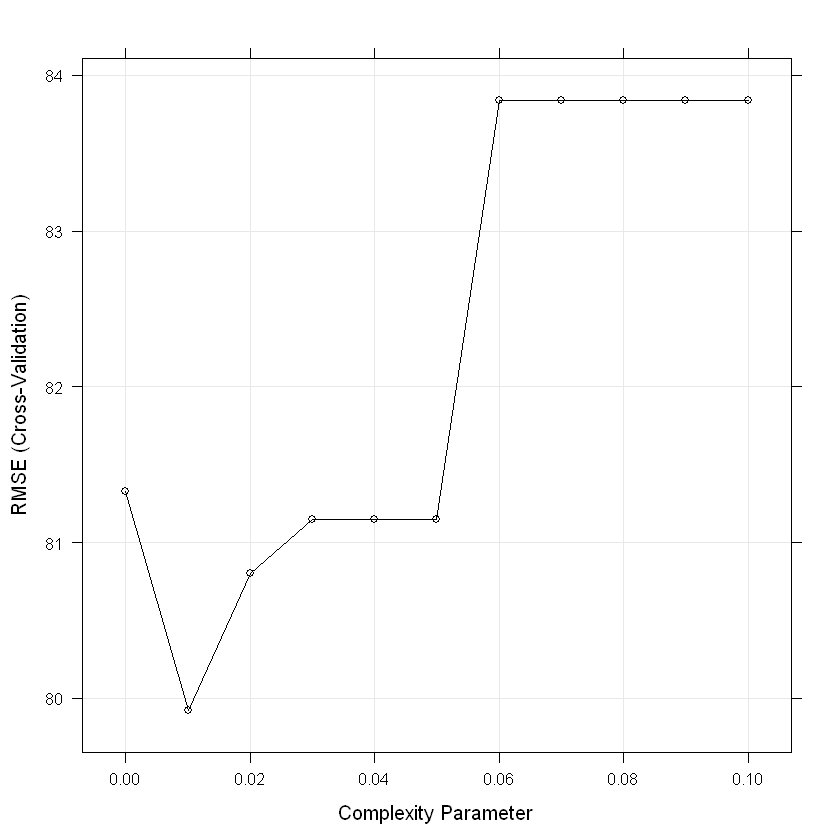

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2171, 2171, 2173, 2174, 2174, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  80.46232  0.2286411  64.62664
  0.01  80.27280  0.1961770  64.31787
  0.02  81.18441  0.1757141  65.38239
  0.03  81.16713  0.1755869  65.30956
  0.04  81.16713  0.1755869  65.30956
  0.05  81.16713  0.1755869  65.30956
  0.06  83.76793  0.1222558  67.79035
  0.07  83.81447  0.1203616  67.72830
  0.08  83.81447  0.1203616  67.72830
  0.09  83.81447  0.1203616  67.72830
  0.10  83.81447  0.1203616  67.72830

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


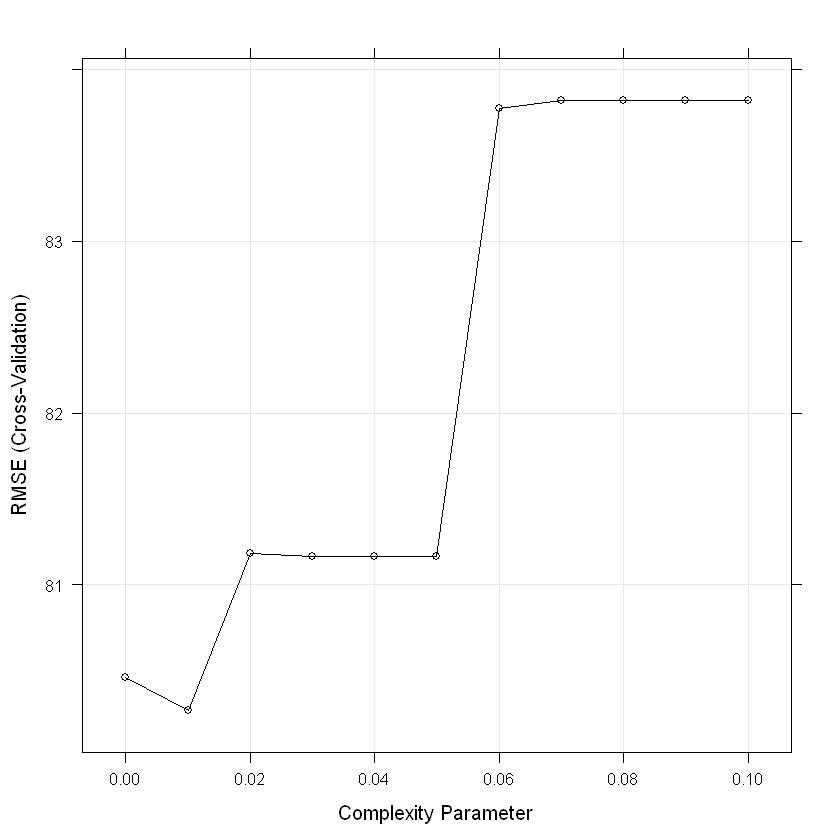

In [134]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
#minbucket_grid=expand.grid(.cp=(5:10))
for(i in 5:10){
    tr=train(readingScore~.,
          data=pisa_train_dt, 
          method="rpart",
          trControl=numFolds,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2173, 2172, 2173, 2172, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  90.78032  0.1647413  72.79861
  0.01  79.71377  0.2087649  63.93785
  0.02  81.39180  0.1732683  65.33374
  0.03  81.94599  0.1625154  66.07720
  0.04  81.94599  0.1625154  66.07720
  0.05  81.94599  0.1625154  66.07720
  0.06  83.83326  0.1211038  67.68014
  0.07  83.84996  0.1214724  67.74468
  0.08  83.84996  0.1214724  67.74468
  0.09  83.84996  0.1214724  67.74468
  0.10  83.84996  0.1214724  67.74468

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


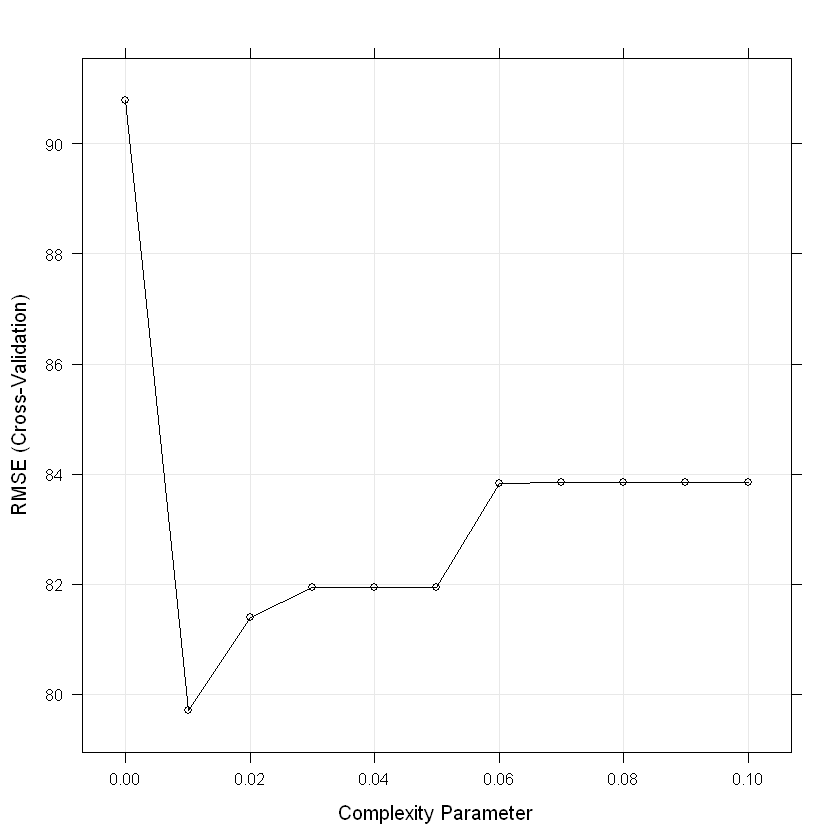

In [127]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
tr=train(readingScore~.,
      data=pisa_train_dt, 
      method="rpart",
      trControl=numFolds,
      tuneGrid= cpGrid,
        # minbucket=minbucket_grid
       control= rpart.control(minsplit = 9)
        )
trellis.par.set(caretTheme())
print(plot(tr))    
print(tr)

expectBachelors               .data_7               .data_4 
         2282409.8932          1070628.9082           542284.6944 
         motherBornUS          fatherBornUS       motherBachelors 
          429366.8017           400091.7925           393018.0663 
                grade               .data_3         englishAtHome 
          293364.1240           269051.2751           257898.8907 
              .data_2       fatherBachelors        read30MinsADay 
          257193.8455           204369.3945           192735.0401 
                 male             preschool          publicSchool 
           43231.9873            41921.9271            34716.5959 
                urban            schoolSize     studentsInEnglish 
           19650.9033            11412.0495             7550.3792 
minutesPerWeekEnglish 
             922.1772

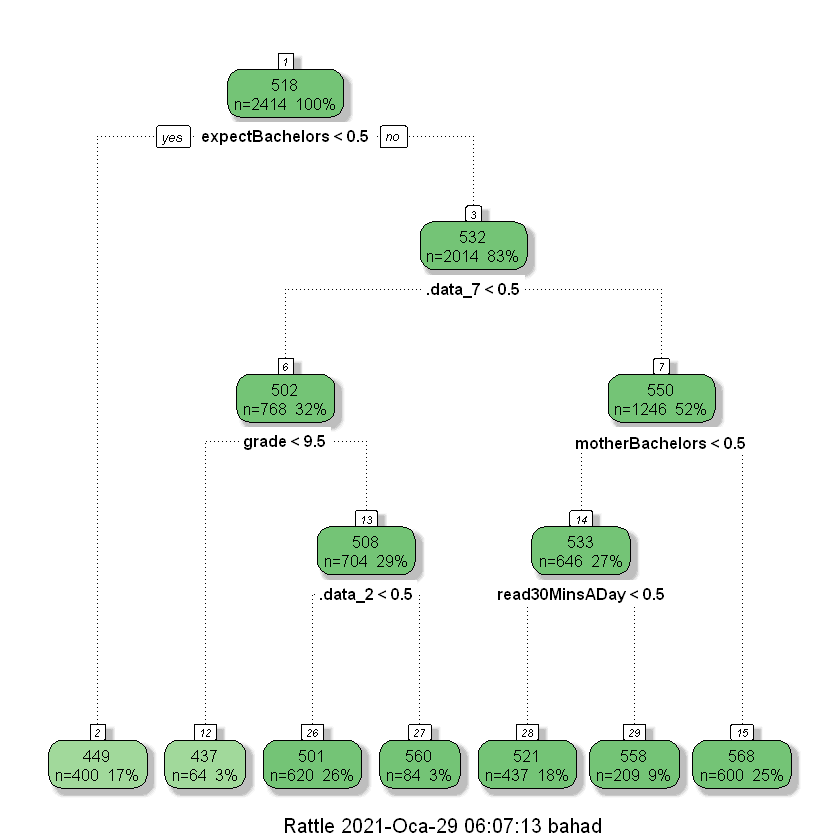

In [128]:
reg_tree_pisa=tr$finalModel
fancyRpartPlot(reg_tree_pisa)
reg_tree_pisa$variable.importance

In [129]:
predicted_pisa_dt=predict(reg_tree_pisa,newdata=pisa_test_dt)

### Performanca Measure

In [133]:
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


## Random Forest(RF)

In [ ]:
rf_grid=expand.grid(mtry = c(4, 6, 8),
                    splitrule = c("gini", "extratrees"),
                    min.node.size = c(5))
rf_grid 

In [ ]:
rf_fit=train(is_expensive ~ ., data = data.frame(classification_data), 
                 method = "ranger", 
                 trControl = fitControl, num.trees=100,
                 tuneGrid = rf_grid) 

In [ ]:
rf_fit
plot(rf_fit)

In [ ]:
random_forest_pisa=randomForest(readingScore~.,data=pisa_train,
                           ntree=300,nodesize=5)
random_forest_pisa

In [ ]:
varImpPlot(random_forest_pisa)

In [ ]:
RandomForest_pisa=predict(random_forest_pisa,newdata=pisa_test)

### Performanca Measure

In [ ]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))

# Stochastic Gradient Boosting(SGB)

In [ ]:
noftrees=100
depth=5
learning_rate=0.01
sampling_fraction=1
boosting_model_pisa=gbm(readingScore~., data=pisa_train ,distribution = "gaussian", n.trees = noftrees,
        interaction.depth = depth, n.minobsinnode = 5, shrinkage =learning_rate ,
        bag.fraction = sampling_fraction)

predicted_pisa_sgb=predict(boosting_model_pisa,newdata=pisa_test,n.trees=noftrees)   

### Performanca Measure

In [ ]:
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

# General Comparision